# Running *GROMACS* on AQE for Polymer Mixture Melt Simulation

This notebook will demonstrate the pipeline to simulate a polymer melt or a blend of polymers in a melt using GROMACS molecular dynamics software.\
A polymer melt refers to a state where a polymer is heated until it becomes a viscous, liquid-like fluid. This is often done to process the polymer into various shapes and forms through methods like injection molding or extrusion.\
A mixture of polymers in a melt means combining two or more different polymers while they are in this liquid state to create a new material with unique properties. This is similar to how metal alloys are made by mixing different metals.\
The pipeline will enable us to do the following:
- [x] Construction of _homopolymer_ with a user defined polymer chain length or molecular weight.
- [x] Construction of _homopolymer melt_ or _homopolymer mixture_.
- [x] Computation of various thermodynamic properties of the melt and polymeric properties.

A homopolymer is a polymer that is made up of only one type of monomer. Essentially, it consists of repeating units of the same molecule. For example, polyethylene is a homopolymer made entirely from ethylene monomers.
Construction of homopolymer means creating a polymer that consists of just one type of monomer, either with a specific chain length or molecular weight. This is in contrast to a copolymer, which would be made from two or more different monomers.

**The objective of this notebook is to enable user to compute:**
- [x] **The glass transition temperature (Tg) of the polymer/polymer mixture:** The glass transition temperature is a critical property in the study of polymers. It refers to the temperature range at which a polymer transitions from a hard, glassy material to a soft, rubbery state. Below the glass transition temperature, the polymer chains are in a rigid and brittle state, but above this temperature, they gain mobility and become more flexible and pliable.
- [x] **Cohesive energy density (CED) of polymer:** Cohesive energy density of a polymer is a measure of the energy required to separate the polymer molecules from each other to an infinite distance. It's essentially a way of quantifying the intermolecular forces within the polymer. In other words, CED gives an idea of how strongly the polymer molecules are attracted to each other. A higher cohesive energy density means the molecules are more strongly bound together, which can influence the material's properties like its solubility, mechanical strength, and glass transition temperature.
- [x] **Polymeric structural properties:** End-to-end distance distribution, radius of gyration and its eigen values.
- [x] **Diffusion coefficient of polymer:** The diffusion coefficient of a polymer is a measure of how quickly polymer molecules move or spread through a medium (like a solvent or another polymer). It indicates the rate at which individual polymer chains travel within the given material. It's important in various applications, such as in Material Science when studying the mobility of polymers and their response to environmental changes, or Polymer Processing when understanding how polymers mix and spread during manufacturing.

The major steps involved in the pipeline is as follows:
- **Step 1:** Load AiiDA profile.
- **Step 2:** User inputs for running the molecular dynamics simulation.
- **Step 3:** Import necessary python packages.
- **Step 4:** Polymer construction from the monomer.
- **Step 5:** Setup for molecular dynamics simulation. (i.e. - energy minimization, equilibration simulation, production simulation)
- **Step 6:** Running the equilibration molecular dynamics simulation.
- **Step 7:** Calculation of equilibrium properties.
- **Step 8:** Visualization of properties and polymer melt system.
- **Step 9:** Setup for molecular dynamics simulation for multiple thermodynamic conditions required for some properties calculation.
- **Step 10:** Running MD simulation at multiple thermodynamic conditions.
- **Step 11:** Calculation of polymer properties and visualization.

We will go through these aformentioned steps step by step.

<div class="alert alert-info">
 ℹ️ Currently the PoC is for linear homopolymer and a blend of 2 polymers only.
</div>

**Step 1:** Load AiiDA profile.\
We load an AiiDA profile. The `load_profile` method will load the default profile if no explicit profile name is specified.

In [18]:
from aiida import load_profile
load_profile()

Profile<uuid='e3eed8e7f41e49b094d7e9107f76a58a' name='gromacs'>

**Step 2:** User inputs for running the molecular dynamics simulation.\
We define a few **_user defined_** parameters which are used throughout the pipeline. The necessary parameters are classified in two group of parameters.\

- **_Parameters for polymer/monomer_**
1. **`monomer_id_list`:** Id of the polymers for the MD simulation.
2. **`monomer_count_per_polymer_list`:** Number of monomer units per polymer for each polymer.
3. **`total_polymer_count`:** Number of polymer units for MD simulations.
4. **`first_polymer_wt_perc`:** Weight percentage of first polymer for MD simulations.

- **MD properties_**
1. **`property_list`:** List of properties to be calculated from the MD simulation.

- **_Parameters for MD simulations (Thermodynamic conditions)_**
1. **`temperature`:** Simulation temperature in Kelvin.
2. **`pressure`:** Simulation pressure in bar.

- **_Parameters for MD simulations (Specific for calculation of some properties)_**
1. **`search_region_Tg`:** Simulation temperature range is given for the properties calculation.
2. **`temperature_incr`:** Simulation temperature increment is given for the properties calculation.

In [19]:
# User inputs

# Monomer inputs
monomer_id_list = [1, 2]                             # id list will be shown in the terminal
monomer_count_per_polymer_list = [8, 15]             # number of monomers in one polymer
total_polymer_count = 200                            # number of polymers to be simulated
first_polymer_wt_perc = 40                           # weight percentage of first polyer

# MD inputs (primary)
temperature = 300.15                                 # simulation temperature (K)
pressure = 1.0                                       # simulation pressure (bar)
property_list = ['Potential', 'Density', 'Tg']       # properties to be calculated

'''
    This will be a seperate cell only asked for user input if there is a requirement.
'''
# Optional parameters for property calculations
# For Tg
search_region_Tg = [255.15, 275.15]                  # user expected Tg
temperature_incr = 10.0                              # no of simulation points

**Step 3:** Import necessary python packages.

In [20]:
# Import basic packages
import pathlib
import os
import numpy as np

# Import aiida packages
from aiida.engine import run, submit
from aiida.engine import calcfunction, WorkChain
from aiida.orm import Bool, Int, Float, Str, Dict, List, SinglefileData, FolderData, Computer
from aiida_shell import launch_shell_job

# Import plotting packages
from IPython.display import display, Image

# Import custom packages
import polymer_constant
from blend_polymerize import PolymerizeWorkChain
import gromacs_setup
import gromacs_analysis

Convert the user input into `aiida.orm` data types accepted by the `node` arguments. 

In [21]:
monomer_id_list = List(monomer_id_list)
monomer_type_count = Int(len(monomer_id_list))

monomer_pdbfname_list = List([])
for monomer_id in monomer_id_list:
    monomer_pdbfname_list.append(polymer_constant.get_pdb(monomer_id))

if len(monomer_pdbfname_list) != monomer_type_count.value:
    raise ValueError('Wrong Input.')

monomer_count_per_polymer_list = List(monomer_count_per_polymer_list)
if len(monomer_count_per_polymer_list) != monomer_type_count.value:
    raise ValueError('Wrong Input.')
first_polymer_wt_perc = Float(first_polymer_wt_perc)

polymer_connection_point_list = List([])
for monomer_id in monomer_id_list:
    polymer_connection_point_list.append(polymer_constant.get_connection_point(monomer_id))
if len(polymer_connection_point_list) != monomer_type_count.value:
    raise ValueError('Wrong Input.')
    
temperature = Float(temperature)
pressure = Float(pressure)
cls_prop_list = polymer_constant.get_classified_property_list(List(property_list))
primary_property_list = List(cls_prop_list[0])
secondary_property_list = List(cls_prop_list[1])

temperature_list = List([])
if secondary_property_list:
    for prop in secondary_property_list.get_list():
        if prop == 'Tg':
            if search_region_Tg[0] > search_region_Tg[1]:
                raise ValueError('Temperature range is not correct.')
            temperature_list = List([search_region_Tg[0] + i * temperature_incr for i in range(0, int((search_region_Tg[1] - search_region_Tg[0])/temperature_incr)+1)])

**Step 4:** Polymer construction from the monomer.

The monomer pdb file is opened and wrapped it in AiiDA's `SinglefieData` data type, which allows it to be stored in the provenance graph.

In [5]:
monomer_list = List([])
for monomer_pdbfname in monomer_pdbfname_list:
    monomer_list.append(SinglefileData(os.getcwd() + '/' + monomer_pdbfname.value))

We use the PDB file containing the monomer structure and use a run(polymerize) workchain to automate the polymerization process. This workchain identifies the bonding sites in the monomer, iteratively connects them to form a polymer, and run till the number of monomer per chain is achieved. The output of this step is a dictionary containing the polymer's structural data wrapped in AiiDA's `SinglefileData` data type and atomic weight of the polymer chain. This streamlined approach eliminates the need for manual intervention.

In [6]:
polymer_data_list = List([])
for imonomer, monomer in enumerate(monomer_list):
    polymer_data_list.append(run(PolymerizeWorkChain, monomer = monomer, monomer_count = monomer_count_per_polymer_list[imonomer], polymer_connection_point_list = polymer_connection_point_list[imonomer]))
    polymer_data_list[imonomer]['polymer_name'] = gromacs_setup.get_polymer_name(Str(monomer.filename))

Polymerization starts for tPBMonomer.pdb ->
8
Polymerization starts for PVAMonomer.pdb ->
15


**Remove this once testing is completed**

**Step 5:** Setup for molecular dynamics simulation.\
We configure the force-field folder and encapsulate it within AiiDA's `FolderData` data type, enabling its storage in the provenance graph. This folder contains the definitions for nonbonded and bonded interactions specific to the chosen force field, which will be utilized throughout the subsequent steps of the workflow.

In [7]:
# Default Parameters
ffdir = os.getcwd() + '/oplsaa.ff'
oplsaa = FolderData(tree=ffdir)

The simulation box length is determined using the `calc_simulation_box_length` function. This calculation is based on the default polymer melt density of 0.40 g/cc and the specified number of polymer chains for the simulation. By leveraging this density, the function ensures that the simulation box is appropriately sized to represent the polymer melt environment accurately, maintaining realistic molecular interactions and spatial arrangements. This calculated box length serves as the foundation for subsequent simulation setup and execution.

In [8]:
max_molecular_weight = 0.0
for polymer_data in polymer_data_list:
    if polymer_data['polymer_molecular_weight'] > max_molecular_weight:
        max_molecular_weight = polymer_data['polymer_molecular_weight']
box_length = gromacs_setup.calc_simulation_box_length(max_molecular_weight, total_polymer_count)

<div class="alert alert-info">
`gmx` is the GROMACS executable which will be executed with several parameters. The `nodes` argument takes a dictionary of `SinglefileData` and `FolderData` which will be copied to the working directory where the `gmx` command is executed. The `oplsaa` in `nodes` are copied to the `oplsaa.ff` folder in the working directory. If the key of the node appears as a placeholder in the `arguments` argument, it is replaced with its filename. 
</div>

`gmx pdb2gmx` is used to generate the forcefield information for the given polymer i.e.  nonbonded and bonded interaction parameters for all the atoms in the polymer

The `gmx pdb2gmx` is expected to generate three outputs of interest:
- `polymer_out.pdb`: `.pdb` file of the polymer.
- `topol.top`: The topology file.
- `posre.itp`: The position restraint file included in the topology file.

In [9]:
# Run `gmx pdb2gmx` to convert the PDB to GROMACS .gro format.
mw_list = List([])

node_pdb2gmxlist = List([])
results_pdb2gmxlist = List([])

node_sc_editconflist = List([])
results_sc_editconflist = List([])

node_sc_eqnptlist = List([])
results_sc_eqnptlist = List([])

itp_fname_list = List([])
posre_fname_list = List([])

itp_list = List([])

for polymer_data in polymer_data_list.get_list():
    mw_list.append(polymer_data['polymer_molecular_weight'])

    name = polymer_data['polymer_name'].value
    pdb = f'{name}_pdb2gmx.pdb'
    top = f'{name}.top'
    posre = f'posre_{name}.itp'
    results_pdb2gmx, node_pdb2gmx = launch_shell_job(
        'gmx',
        arguments='pdb2gmx -f {polymer} -o {pdb} -water spce -ff oplsaa -p {top} -i {posre}',
        nodes={
            'polymer': polymer_data['polymer'],
            'pdb': Str(pdb),
            'folder': oplsaa,
            'top': Str(top),
            'posre': Str(posre),
        },
        filenames={
            'folder': 'oplsaa.ff',
        },
        outputs=[pdb, top, posre],
        metadata={'call_link_label': 'polymerize', 'options': {'redirect_stderr': True}},
    )
    node_pdb2gmxlist.append(node_pdb2gmx)
    results_pdb2gmxlist.append(results_pdb2gmx)
    posre_fname_list.append(posre)

    itpfname = f'{name}.itp'
    itp_list.append(gromacs_setup.convert_top_to_itp(results_pdb2gmx[f'{name}_top'], Str(itpfname)))
    itp_fname_list.append(itp_list[len(itp_list)-1].filename)

    # energy minimization and equilibration of single chain of polymer
    results_sc_editconf, node_editconf_sc = launch_shell_job(
        'gmx',
        arguments='editconf -f {gro} -d 1.0 -o polymer_out_box.pdb',
        nodes={
            'gro': results_pdb2gmx[f'{name}_pdb2gmx_pdb'],
        },
        outputs=['polymer_out_box.pdb'],
        metadata={'call_link_label': 'pdb2gmx', 'options': {'redirect_stderr': True}},
    )

    # Run `gmx grompp` to pre-process the parameters for energy minimization.
    results_grompp_sc_em, node_grompp_sc_em = launch_shell_job(
        'gmx',
        arguments='grompp -f {mdp} -c {gro} -p {top} -o em_sc.tpr',
        nodes={
            'mdp': gromacs_setup.get_em_mdp(),
            'gro': results_sc_editconf['polymer_out_box_pdb'],
            'top': results_pdb2gmx[f'{name}_top'],
            'posre': results_pdb2gmx[f'posre_{name}_itp'],
            'folder': oplsaa,
        },
        filenames={
            'folder': 'oplsaa.ff'
        },
        outputs=['em_sc.tpr'],
        metadata={'call_link_label': 'pdb2gmx', 'options': {'redirect_stderr': True}},
    )
    #print(results_grompp_sc_em['stdout'].get_content())
    
    # Run `gmx mdrun` to run the energy minimization.
    results_sc_em, node_sc_em = launch_shell_job(
        'gmx',
        arguments='mdrun -v -deffnm em_sc -s {tpr}',
        nodes={
            'tpr': results_grompp_sc_em['em_sc_tpr'],
        },
        outputs=['em_sc.*'],
        metadata={'call_link_label': 'em_sc_grompp', 'options': {'redirect_stderr': True}},
    )
    #print(results_sc_em['stdout'].get_content())

    # Run `gmx grompp` to pre-process the parameters for equilibration
    results_grompp_sc_eqnpt, node_grompp_sc_eqnpt = launch_shell_job(
        'gmx',
        arguments='grompp -f {mdp} -c {gro} -p {top} -o eqnpt_sc.tpr',
        nodes={
            'mdp': gromacs_setup.get_nvt_mdp(temperature = temperature),
            'gro': results_sc_em['em_sc_gro'],
            'top': results_pdb2gmx[f'{name}_top'],
            'posre': results_pdb2gmx[f'posre_{name}_itp'],
            'folder': oplsaa,
        },
        filenames={
            'folder': 'oplsaa.ff'
        },
        outputs=['eqnpt_sc.tpr'],
        metadata={'call_link_label': 'em_sc', 'options': {'redirect_stderr': True}},
    )
    #print(results_grompp_sc_em['stdout'].get_content())
    
    # Run `gmx mdrun` to run the energy minimization.
    results_sc_eqnpt, node_sc_eqnpt = launch_shell_job(
        'gmx',
        arguments='mdrun -v -deffnm eqnpt_sc -s {tpr}',
        nodes={
            'tpr': results_grompp_sc_eqnpt['eqnpt_sc_tpr'],
        },
        outputs=['eqnpt_sc.*'],
        metadata={'call_link_label': 'eqnpt_sc_grompp', 'options': {'redirect_stderr': True}},
    )
    #print(results_sc_eqnpt['stdout'].get_content())
    node_sc_eqnptlist.append(node_sc_eqnptlist)
    results_sc_eqnptlist.append(results_sc_eqnpt)

In [10]:
polymer_count_list = gromacs_setup.get_polymer_count(total_polymer_count, first_polymer_wt_perc, mw_list)
top_file = gromacs_setup.get_top(itp_fname_list, posre_fname_list, polymer_count_list)

<div class="alert alert-info">
These output files will be used in the upcoming steps in the pipeline. To capture these output files in the AiiDA's provenance graph, these filenames are declared in the `output` argunent. `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

Similar to the previous steps, GROMACS creates a simulation box where mutiple chains of the polymer will be inserted for the MD simulations. From the previous step, `.pdb` file of the single polymer chain is used to replicate the polymer chain inside the simulation box. In the output, we get a simulation box containing `polymer_count` number of polymers.

In [11]:
node_insertlist = List([])
results_insertlist = List([])
for ipolymer, polymer_count in enumerate(polymer_count_list):
    run = Bool(True)
    iter = 0
    while run.value:
        if ipolymer == 0:
            results_insert, node_insert = launch_shell_job(
                'gmx',
                arguments='insert-molecules -box {box_length} -ci {polymer} -nmol {polymer_count} -try 999 -o melt.pdb',
                nodes={
                    'box_length': box_length,
                    'polymer': results_sc_eqnptlist[ipolymer]['eqnpt_sc_gro'],
                    'polymer_count': Int(polymer_count),
                },
                outputs=['melt.pdb'],
                metadata={'call_link_label': 'polymerize', 'options': {'redirect_stderr': True}},
            )
        else:
            results_insert, node_insert = launch_shell_job(
                'gmx',
                arguments='insert-molecules -f {melt_pdb} -box {box_length} -ci {polymer} -nmol {polymer_count} -try 999 -o melt.pdb',
                nodes={
                    'melt_pdb': results_insertlist[ipolymer-1]['melt_pdb'],
                    'box_length': box_length,
                    'polymer': results_sc_eqnptlist[ipolymer]['eqnpt_sc_gro'],
                    'polymer_count': Int(polymer_count),
                },
                outputs=['melt.pdb'],
                metadata={'call_link_label': 'polymerize', 'options': {'redirect_stderr': True}},
            )
        polymer_count_inserted = gromacs_setup.check_insert_molecules(results_insert['stdout'], Int(polymer_count))
        if polymer_count_inserted.value != polymer_count:
            run = Bool(True)
            iter += 1
            box_length = Float(box_length + 5.0)
            if iter > 100:
                polymer_count_list[ipolymer] = Int(polymer_count_inserted.value)
                print(f'WARNING: {polymer_count_inserted.value} polymers are inserted in the simulation box.')
                run = Bool(False)
        else:
            run = Bool(False)
            node_insertlist.append(node_insert)
            results_insertlist.append(results_insert)

While running the `pdb2gmx` command we have created the topology for one single polymer chain. However, in the `topol.top` file we have to provide the number of polymer chain present in the simulation box. Therefore, we are updating the number of molecules line from 1 to `polymer_count` using the `sed` command.

<div class="alert alert-info">
The output `topol.top` file is declared in the `output` argunent where `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

**Prerequisite for MD simulations and simulation box preparation is completed and we can proceed to run the molecular dynamics simulation.**

`gmx grompp` is used to generate a `.tpr` file written in binary format which has all the necessary input information for running the MD simulation.

The `gmx grompp` takes the input of three necesary files to generate the `.tpr` file.
- [x] `.mdp`: The molecular dynamics parameters.
- [x] `.gro`: The coordinate information of all the polymer chains present in the simulation box.
- [x] `.top`: The tolology file of the polymer. Also, this has the information of number of polymers present in the simulation box.

In [12]:
# Run `gmx grompp` to pre-process the parameters for energy minimization.
nodes = {}
for i_itp in range(len(itp_list)):
    nodes[f'itp{i_itp}'] = itp_list[i_itp]
    name = polymer_data_list[i_itp]['polymer_name'].value
    nodes[f'posre_{i_itp}'] = results_pdb2gmxlist[i_itp][f'posre_{name}_itp']
nodes['mdp'] = gromacs_setup.get_em_mdp()
nodes['gro'] = results_insertlist[len(results_insertlist)-1]['melt_pdb']
nodes['top'] = top_file
nodes['folder'] = oplsaa
    
results_grompp_em, node_grompp_em = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o em.tpr',
    nodes=nodes,
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['em.tpr'],
    metadata={'call_link_label': 'insertbox', 'options': {'redirect_stderr': True}},
)
#print(results_grompp_em['stdout'].get_content())

As we are proceeding towards the MD simulation, we must ensure that the simulations are running on the HPC to maximize the performance. Therefore, we are loading the AiiDA variable `Computer` where the information about the HPC will be given to submit the simulation at HPC.

In [13]:
computer = Computer.collection.get(label='localhost')
computer.set_default_mpiprocs_per_machine(8)

Now, the generated `.tpr` file is used for running the molecular dynamics simulation. We can run the `gmx mdrun` to run the energy minimization step. The variable `computer` is used in the `launch_shell_job` command ensures the use of HPC while running the simulation.

In [14]:
# Run `gmx mdrun` to run the energy minimization.
results_em, node_em = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm em -s {tpr}',
    nodes={
        'tpr': results_grompp_em['em_tpr'],
    },
    outputs=['em.*'],
    metadata={'call_link_label': 'em_grompp', 'options': {'redirect_stderr': True, 'computer': computer, 'withmpi': True}},
)
#outputs=['output.edr', 'output.gro', 'output.log'],
#print(results_em['stdout'].get_content())

Similar to the previous `gmx grompp` step, we can proceed with NPT equilibration step where the molecular dynamics simulation will be performed at the given thermodynamic conditions given by the user.

In [15]:
if primary_property_list:
    nodes = {}
    for i_itp in range(len(itp_list)):
        nodes[f'itp{i_itp}'] = itp_list[i_itp]
        name = polymer_data_list[i_itp]['polymer_name'].value
        nodes[f'posre_{i_itp}'] = results_pdb2gmxlist[i_itp][f'posre_{name}_itp']
    nodes['mdp'] = gromacs_setup.get_npt_mdp(temperature = temperature, pressure = pressure)
    nodes['gro'] = results_em['em_gro']
    nodes['top'] = top_file
    nodes['folder'] = oplsaa
    
    # Run `gmx grompp` to pre-process the parameters for energy minimization.
    results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
        'gmx',
        arguments='grompp -f {mdp} -c {gro} -p {top} -o npt.tpr',
        nodes=nodes,
        filenames={
            'folder': 'oplsaa.ff'
        },
        outputs=['npt.tpr'],
        metadata={'call_link_label': 'em_mdrun', 'options': {'redirect_stderr': True}},
    )
    #print(results_grompp_eqnpt['stdout'].get_content())

**Step 6:** Running the molecular dynamics simulation.
The generated `.tpr` file is used for running the molecular dynamics simulation for NPT equilibration. We can run the `gmx mdrun` to run the NPT equilibration step.

In [16]:
if primary_property_list:
    # Run `gmx mdrun` to run the equilibrium NPT simulations
    results_eqnpt, node_eqnpt = launch_shell_job(
        'gmx',
        arguments='mdrun -v -deffnm npt -s {tpr}',
        nodes={
            'tpr': results_grompp_eqnpt['npt_tpr'],
        },
        outputs=['npt.*'],
        metadata={'call_link_label': 'eqnpt_grompp', 'options': {'redirect_stderr': True, 'computer': computer, 'withmpi': True}},
    )
    #print(results_eqnpt['stdout'].get_content())

**Step 7:** Calculation of equilibrium properties.

<div class="alert alert-info">
Using `gmx energy` command we can calculate and plot the primary properties for the simulated polymer system.
</div>

<div class="alert alert-info">
The input for `gmx energy` is the `output.edr` from the `results_eqnpt`. Here we first pass `10` which corresponds to the potential energy, followed by `0` which finalizes the selection and completes the prompt. The `output` file of this step saved as GROMACS generated `.xvg` format.
</div>

In [17]:
if primary_property_list:
    primary_property_str = ''
    for iproperty in primary_property_list.get_list():
        primary_property_str += iproperty + '\n'
    primary_property_str += '0'
    
    # Run `gmx energy` to extract the potential energy during the energy minimization.
    results_energy, node_energy = launch_shell_job(
        'gmx',
        arguments='energy -f {edr} -o energy.xvg',
        nodes={
            'edr': results_eqnpt['npt_edr'],
            'stdin': SinglefileData.from_string(primary_property_str),
        },
        outputs=['energy.xvg'],
        metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
    )
    
    average_eq_property_list = gromacs_analysis.get_average_property(results_energy['stdout'], primary_property_list)
    print(average_eq_property_list)
    print('Average equilibrium properties:\n')
    for average_property in average_eq_property_list:
        print(f'{average_property[0]}: {average_property[1]} {average_property[2]}\n')

uuid: 7fce273c-fece-4d99-86e9-79c371644fa8 (pk: 125036) value: [['Potential', '69751.5', '(kJ/mol)'], ['Density', '406.703', '(kg/m^3)']]
Average equilibrium properties:

Potential: 69751.5 (kJ/mol)

Density: 406.703 (kg/m^3)



**Step 8:** Visualization of properties and polymer melt system.
To visualize the data, first we need to import necessary python packages to be installed.

We import the `gromacs_analysis`to create the plot for properties calculated in the previous step.

plotting ->  0
plotting ->  1


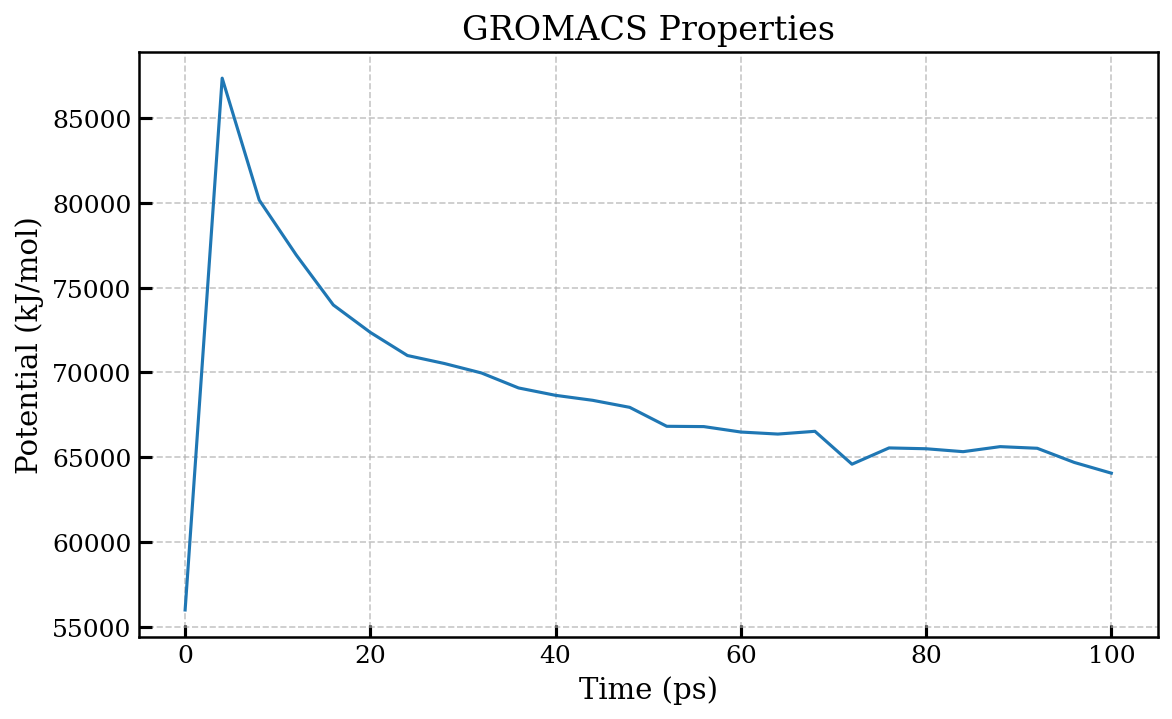

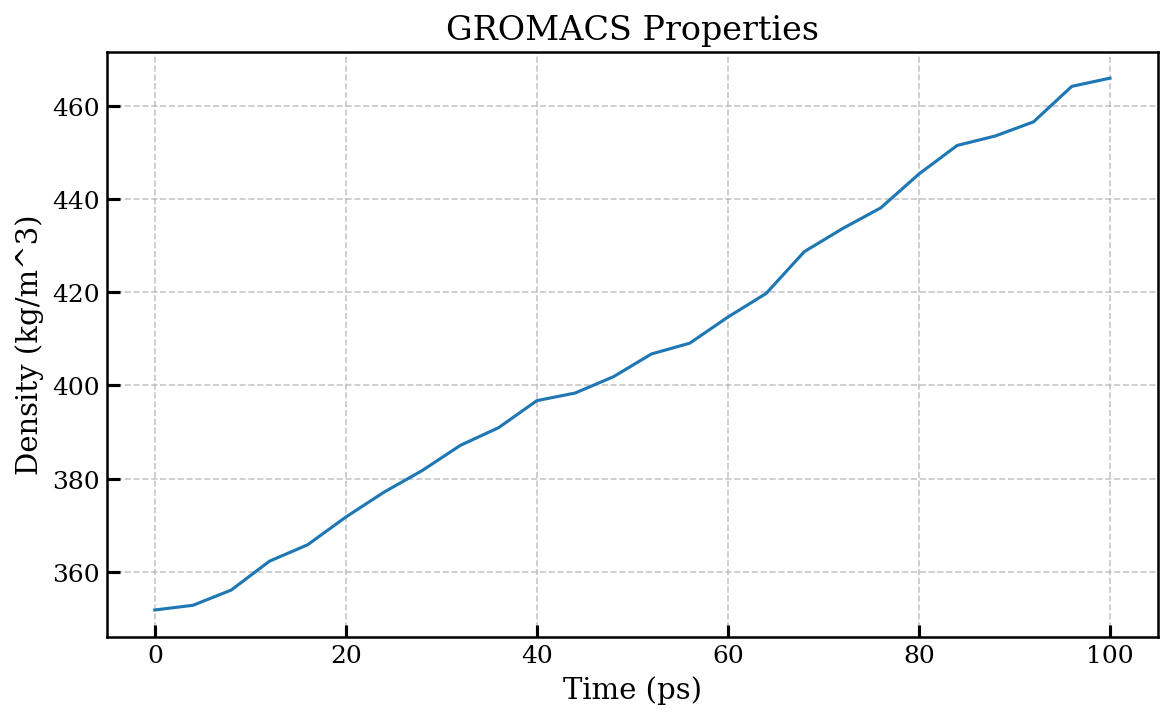

<Figure size 800x500 with 0 Axes>

In [18]:
if primary_property_list:
    plot = gromacs_analysis.create_time_plot(results_energy['energy_xvg'])
    for iplot in plot:
        display(Image(filename=iplot))

**Step 9:** Setup for molecular dynamics simulation for multiple thermodynamic conditions required for some properties calculation.

We are going to perform multiple molecular dynamics simulation by varying temperatures or varying pressure or varying both temperature and pressure. This variation in temeprature and pressure is controlled based on the user input.

As the varying parameters are temperature and pressure, we do not need to perform the complete gromacs setup as we performed previously. We are executing the GROMACS `grompp` command to generate `.tpr` file for all the thermodynamics conditions (i.e. - temperature range or pressure range or both.) These `.tpr` files will be used to run the molecular dynamics simulations. 

<div class="alert alert-info">
A `AiiDA's` list of `AiiDA node` instances are created for temperature and pressure range. These `node` instances will be called in the later step to run the molecular dynamics simulations.
</div>

In [19]:
if secondary_property_list:
    node_grompplist = List([])
    results_grompplist = List([])
    
    for i, temperature_i in enumerate(temperature_list.get_list()):
        id = Int(i)
        temperature_curr = Float(temperature_i)
        
        nodes = {}
        for i_itp in range(len(itp_list)):
            nodes[f'itp{i_itp}'] = itp_list[i_itp]
            name = polymer_data_list[i_itp]['polymer_name'].value
            nodes[f'posre_{i_itp}'] = results_pdb2gmxlist[i_itp][f'posre_{name}_itp']
        nodes['mdp'] = gromacs_setup.get_npt_mdp(id = id, temperature = temperature_curr, pressure = pressure)
        nodes['gro'] = results_em['em_gro']
        nodes['top'] = top_file
        nodes['folder'] = oplsaa
        tpr = f'npt-{i}.tpr'
        nodes['tpr'] = Str(tpr)
        results_grompp_eqnpt_iter, node_grompp_eqnpt_iter = launch_shell_job(
            'gmx',
            arguments='grompp -f {mdp} -c {gro} -p {top} -o {tpr}',
            nodes=nodes,
            filenames={
                'folder': 'oplsaa.ff'
            },
            outputs=[tpr],
            metadata={'options': {'redirect_stderr': True}},
        )
        node_grompplist.append(node_grompp_eqnpt_iter)
        results_grompplist.append(results_grompp_eqnpt_iter)

**Step 10:** Running MD simulation at multiple thermodynamic conditions.

The series of molecular dynamics simulation is running. A `list` of ouput will be generated for different thermodynamic conditions.

In [20]:
if secondary_property_list:
    # Run `gmx mdrun` to run the equilibrium NPT simulations at different T & P
    node_eqnptlist = List([])
    results_eqnptlist = List([])
    
    for i, temperature_ele in enumerate(temperature_list.get_list()):
        #print(i, temperature_ele, type(temperature_ele), type(i))
        tpr = f'npt_{i}_tpr'
        output = f'npt-{i}'
        results_eqnpt, node_eqnpt = launch_shell_job(
            'gmx',
            arguments='mdrun -v -deffnm {output} -s {tpr}',
            nodes={
                'tpr': results_grompplist[i][tpr],
                'output': Str(output),
            },
            outputs=[f'{output}.edr', f'{output}.gro', f'{output}.log', f'{output}.xtc'],
            metadata={'options': {'redirect_stderr': True, 'computer': computer, 'withmpi': True}},
        )
        node_eqnptlist.append(node_eqnpt)
        results_eqnptlist.append(results_eqnpt)

**Step 11:** Calculation of polymer properties and visualization.

Secondary properties for this system at all the thermodynamic condtions are getting calculated.

In [21]:
if secondary_property_list:
    gromacs_property_list = polymer_constant.get_all_gromacs_property_list(secondary_property_list)
    secondary_property_str = ''
    for iproperty in gromacs_property_list.get_list():
        secondary_property_str += iproperty + '\n'
    secondary_property_str += '0'
    
    node_energylist = List([])
    results_energylist = List([])
    average_property_list = List([])
    
    for i, temperature_ele in enumerate(temperature_list.get_list()):
        edr = f'npt_{i}_edr'
        output = f'energy-{i}.xvg'
        results_energy, node_energy = launch_shell_job(
            'gmx',
            arguments='energy -f {edr} -o {output}',
            nodes={
                'edr': results_eqnptlist[i][edr],
                'output': Str(output),
                'stdin': SinglefileData.from_string(secondary_property_str),
            },
            outputs=[f'{output}'],
            metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
        )
        node_energylist.append(node_energy)
        results_energylist.append(results_energy)

        average_property_list.append(gromacs_analysis.get_average_property(results_energy['stdout'], gromacs_property_list).get_list())

Plotting data for calculating: Tg


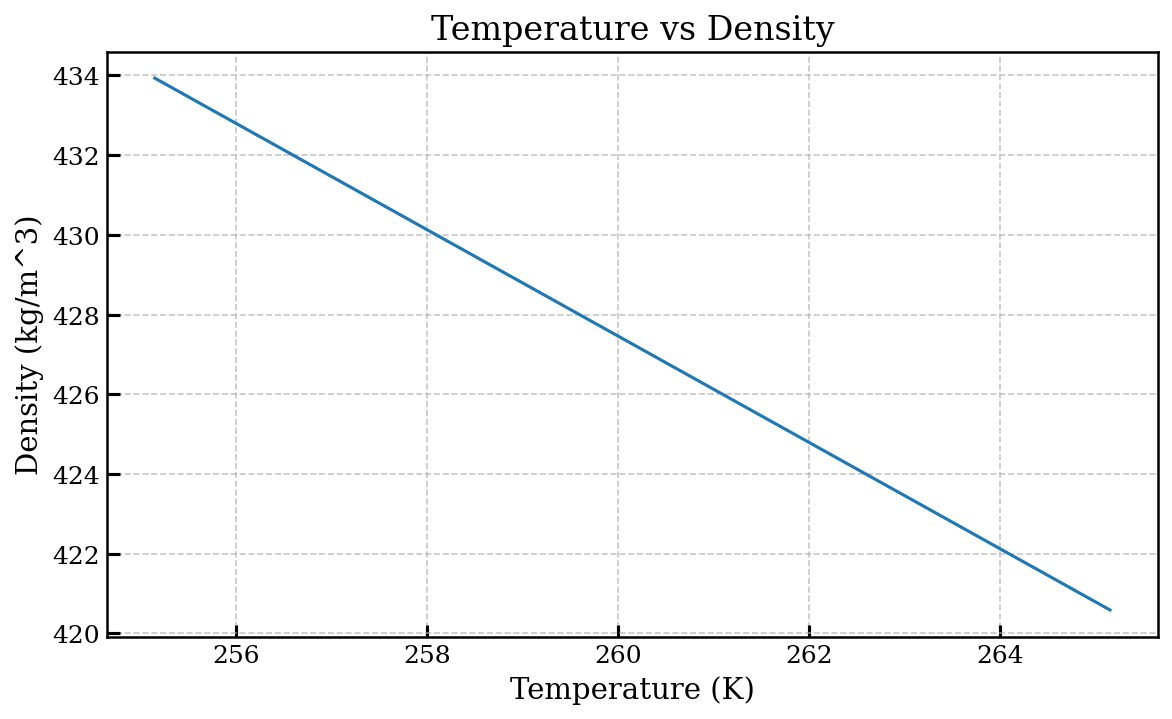

<Figure size 800x500 with 0 Axes>

In [22]:
if secondary_property_list:
    for iproperty in secondary_property_list:
        plot = List([])
        print(f'Plotting data for calculating: {iproperty}')
        if iproperty == 'Tg':
            plot = gromacs_analysis.create_tg_plot(temperature_list, average_property_list)

        if plot:
            for iplot in plot:
                display(Image(filename=iplot))